観測できない不均質さを内包しているデータに対処するために、一般化線形混合モデルを導入したが、ランダム効果の発生源が増えるにしたがって数値的な最尤推定に要する計算時間が長くなったり、最尤推定値の探索そのものが困難になります。

このような複雑な統計モデルの当てはめで威力を発揮するのが、マルコフ連鎖モンテカルロ法（MCMC）である。

あるデータに対してMCMCアルゴリズムを適用すると、推定結果はある確率分布からのランダムなサンプルとして得られる。得られた結果はMCMCサンプルと呼ばれる。

とりあえずは、MCMCアルゴリズムは多変量の確率分布からの巧妙な乱数発生方法であり、統計モデルを観測データに当てはめるとMCMCサンプルが得られると考えてください。

## 8.1種子の生存確率（個体差なし）
各植物個体8個の種子の生死の問題

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

data = np.array([4,3,4,5,5,2,3,1,4,0,1,5,5,6,5,4,4,5,3,4])

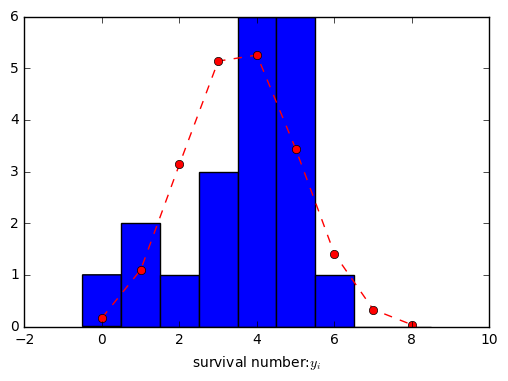

In [2]:
#分布の表示、真の分布はq=0.45の二項分布
x = np.arange(-0.5,9.5,1.)
x_int = np.arange(0,9,1)
plt.hist(data,bins=x)
plt.plot(x_int,stats.binom.pmf(x_int,8,0.45)*20,'--o',color='r') #真の確率分布
plt.xlabel('survival number:$y_{i}$')
plt.show()

大体二項分布に従っている。二項分布したがっているとの仮定のもと、最大対数尤度の式から微分して簡単にパラメータは求められる。けど、ここではGLMを使う。

In [3]:
const = np.ones(data.shape[0])
model = sm.GLM(np.array([data,8-data]).T,const,family=sm.families.Binomial())
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           ['y1', 'y2']   No. Observations:                   20
Model:                            GLM   Df Residuals:                       19
Model Family:                Binomial   Df Model:                            0
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -37.748
Date:                Sat, 04 Feb 2017   Deviance:                       28.722
Time:                        15:05:07   Pearson chi2:                     24.5
No. Iterations:                     5                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.1754      0.159     -1.105      0.269        -0.487     0.136
==============================================================================
"""

In [4]:
q = 1 / (1+np.exp(-result.params[0]))
q

0.45624999999999993

生存確率は0.46程度と推定された。

## 8.2　ふらふら試行錯誤による最尤推定
試行錯誤による最尤推定法では、qをいい加減にきめて、そのqを初期点にしてqを増減させながら対数尤度が高くなるqを逐次的に探していきます。

In [5]:
y = np.arange(0.01,1.0,0.01)
log_likeliwoods = np.array([stats.binom.logpmf(data,8,p).sum() for p in y])

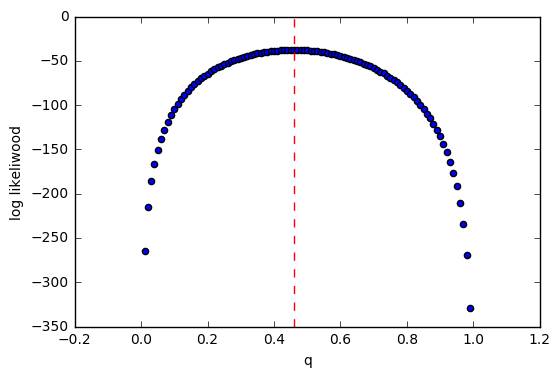

In [6]:
plt.scatter(y,log_likeliwoods)
plt.axvline(y[np.argmax(log_likeliwoods)],c='r',linestyle='--')
plt.xlabel('q')
plt.ylabel('log likeliwood')
plt.show()

In [7]:
print('最大対数尤度のq:%f')%y[np.argmax(log_likeliwoods)]

最大対数尤度のq:0.460000


ふらふら試行の最尤推定の手順は以下の通り
- qは隣の値にしか変化できないとする
- ランダムに右隣か左隣かを選択し、対数尤度が現在のqよりも高ければそちらに移動する。

In [8]:
np.random.randint(2,size=100)

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1])

In [9]:
def series_llf(q,steps=100):
    series = [[0,q]]
    llh = np.sum(stats.binom.logpmf(data,8,q))
    for i in range(steps):
        random = np.random.randint(2)
        if random == 1:
            cal = stats.binom.logpmf(data,8,q+0.01).sum()
            if llh < cal:
                llh = cal
                q += 0.01
        else:
            cal = stats.binom.logpmf(data,8,q-0.01).sum()
            if llh < cal:
                llh = cal
                q -= 0.01
        
        series.append([i+1,q])
        
    return np.array(series)   

init_3 = series_llf(0.3)
init_6 = series_llf(0.6)

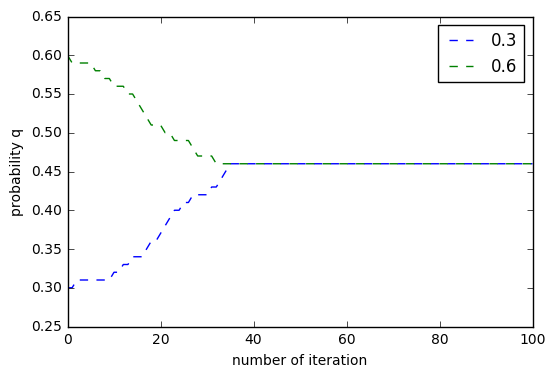

In [10]:
plt.plot(init_3[:,0],init_3[:,1],'--',label='0.3')
plt.plot(init_6[:,0],init_6[:,1],'--',label='0.6')
plt.legend(loc='upper right')
plt.xlabel('number of iteration')
plt.ylabel('probability q')
plt.show()

このようなルールにしたがってqを変化させていくと、とこどころつまづきながらも、qの初期値にかかわりなく、対数尤度の山を登りながらqの最尤推定値の方向に変化していく。

## 8.3 メトロポリス法
MCMCアルゴリズムの中で最も簡単なメトロポリス法を扱う。先ほどの過程に少し手を加えるとメトロポリス法になる。
- パラメータqの初期値を選ぶ
- qを増やすか減らすかをランダムに決める。（新しく選んだqの値をq_newとする）
- q_newにおいて尤度がおおきくなるならqの値をq_newに更新する。
- q_newで尤度が小さくなる場合であっても、確率rでqの値をq_newに更新する。

４つめのルールを追加すると、メトロポリス法になる。なおrは以下の値で設定する。
$$r=\frac{L(q_{new})}{L(q)}$$

この式から明らかなように、尤度比が小さいほど移動しやすいというルールになっている。つまり、最大尤度付近でふらつきやすい。

MCMCアルゴリズムでは、一つのステップの中で前の状態qに基づいて新しい状態q_newを作り出しているので、マルコフ連鎖になっている。

また、一般に乱数を利用した計算アルゴリズムはモンテカルロ法と呼ばれています。

### 8.3.1メトロポリス法でサンプリングしてみる。

In [11]:
def series_llf_metoro(prob,size):
    llf = stats.binom.logpmf(data,8,prob).sum()
    series = [[0,prob,llf]]
    for i in range(size):
        random = np.random.randint(2)
        if random==1:
            cal = stats.binom.logpmf(data,8,prob+0.01).sum()
            if llf < cal:
                llf = cal
                prob += 0.01
            elif np.random.rand() < np.exp(cal-llf):
                llf = cal
                prob += 0.01
        else:
            cal = stats.binom.logpmf(data,8,prob-0.01).sum()
            if llf < cal:
                llf = cal
                prob -= 0.01
            elif np.random.rand() < np.exp(cal-llf):
                llf = cal
                prob -= 0.01           
        series.append([i+1,prob,llf])
    
    return np.array(series)

init_3_100 = series_llf_metoro(0.3,100)
init_3_1000 = series_llf_metoro(0.3,1000)
init_3_10000 = series_llf_metoro(0.3,10000)

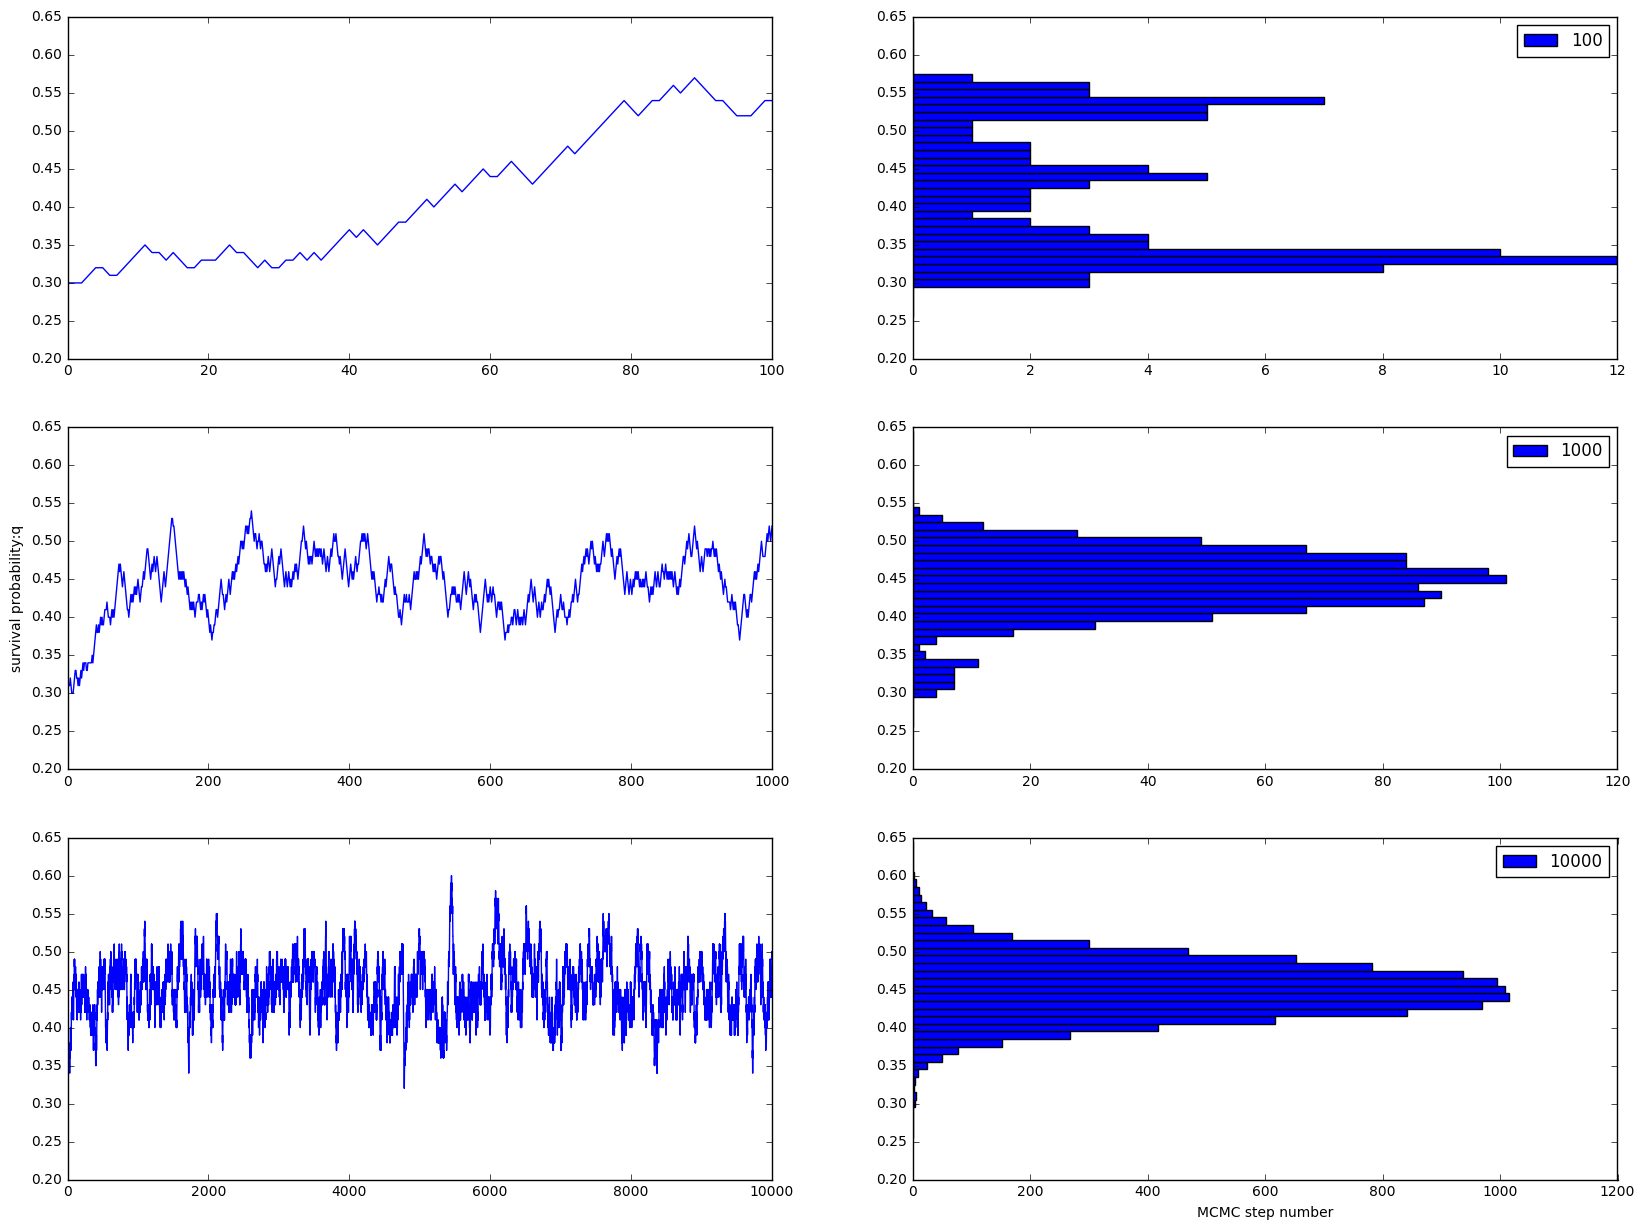

In [15]:
fig,ax = plt.subplots(3,2,figsize=(20,15))
steps = [init_3_100,init_3_1000,init_3_10000]
for i,step in enumerate(steps):
    ax[i][0].plot(step[:,0],step[:,1])
    ax[i][0].set_ylim((0.2,0.65))
    ax[i][1].hist(step[:,1],orientation='horizontal',bins=np.arange(0.245,0.655,0.01),label=str(step.shape[0]-1))
    ax[i][1].legend()
ax[1][0].set_ylabel('survival probability:q')
ax[2][1].set_xlabel('MCMC step number')

対数尤度は増大、あるいはその場に停滞するだけでなく、減少するステップもある。また、一旦対数尤度が最大になるqに達しても、そこからずり落ちるところも異なっている。

最尤推定法の時と違って、どこかにある一番いい値に到達するわけではない。

MCMCアルゴリズムの目的は何か特定の値の探索ではなく、ステップ数とともに変化するパラメータの値の生成です。これをサンプリングと呼ぶ。このようなサンプリングをMCMC法を使った統計モデルの当てはめに相当する。

スッテプ数が増えると、ヒストグラムの形状が確率密度関数に似たものになっていく。この確率分布はこの例題の統計モデルと、メトロポリス法によって決まるマルコフ連鎖の定常分布である。

メトロポリス法の適用によってこの分布からランダムサンプルが得られているようです。

このようなサンプリングが、MCMC法を使った統計モデルの当てはめに相当する。

### 8.3.2マルコフ連鎖の定常分布
定常分布とは、ある変数qのマルコフ連鎖が一定の条件（今回は天下り的に満たしている）を満たしている時に、そのマルコフ連鎖から発生するqの値が従う確率分布です。

ここでは、定常分布を$p(q|{\bf Y})$と表記します。

定常分布$p(q|{\bf Y})$を近似できるようなqの標本集団を得るためには十分な数のMCMCサンプリングが必要です。メトロポリス法の場合、あるqとそこから生成される新しいqの間には相関があります。効率の良いMCMCサンプリング実現するためにはこの相関を低くするようなアルゴリズムにする必要があります。

### 8.3.3この定常分布は何を表す分布なのか？
MCMCアルゴリズムのひとつであるメトロポリス法によって生存確率qの値がサンプルされ、定常分布$p(q|{\bf Y})$が推定可能になりました。この分布は何を表しているのでしょうか？

この例題について言えば、定常分布$p(q|{\bf Y})$は尤度$L(q)$に比例する確率分布です。尤度$L(q)$に比例する離散化したqの確率分布とは以下のように定義されます。
$$p(q|{\bf Y})=\frac{L(q)}{\sum_{q}L(q)}$$

この分母はすべての$L(q)$を足しあわせた値で、データ${\bf Y}$だけに依存する定数なので、$p(q|{\bf Y}) \propto L(q)$という比例関係にあります。

ここまでやってきたことをまとめると。
- ある観測データYを説明するために、二項分布を部品とする統計モデルを作成。
- このモデルとメトロポリス法を使ってMCMCサンプリングをした
- MCMCサンプリングから、尤度に比例するqの確率分布$p(q|{\bf Y})$を推定できるようなサンプルが得られた。

$p(q|{\bf Y})$は尤度に比例するため、あるデータ${\bf Y}$に統計モデルをあてはめたときにqが取る値の確率分布と解釈することができる。

またこの標本から得られる統計量を計算すると、推定されたパラメータの分布と現象の対応関係を検討したり、統計モデルによる様々な予測ができそうです。

In [13]:
y = np.arange(0.25,0.66,0.01)
log_likeliwoods = np.array([stats.binom.logpmf(data,8,q).sum() for q in y])
likeliwoods = np.exp(log_likeliwoods)
P_q_Y = likeliwoods / likeliwoods.sum()

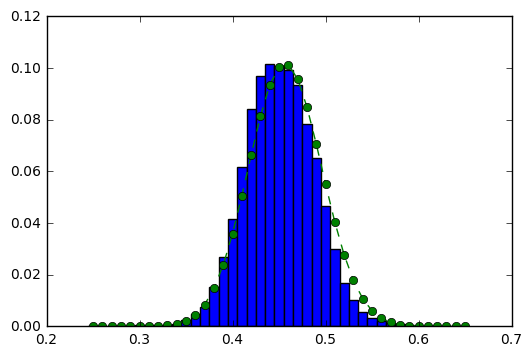

In [14]:
plt.hist(init_3_10000[:,1],bins=np.arange(0.245,0.655,0.01),weights=np.ones(len(init_3_10000[:,1]))*0.0001)
plt.plot(y,P_q_Y,'--o')
plt.show()

## 8.4MCMCサンプリングとベイズ統計モデル
MCMCサンプリングは、統計モデルを観測データに当てはめる方法の一つであり、その結果として、与えられたデータとモデルのもとでのパラメータの確率分布が得られました。ただし、確率分布という表現は留保なしに使っていい表現ではありません。

最尤推定法による推定は、統計学の枠組みの一つである頻度主義を前提にしていると言え、この前提の基では「パラメータqの分布」と言った考え方はありえません。頻度主義の基ではqはある一つの真の値だと措定されて、それに対応する推定値もデータに基づいて決まる１個の値で、確率変数ではありません。

これに対応して、統計モデルのパラメータを確率分布としてあつかう枠組みとしてベイズ統計学が挙げられる。ベイズ統計学で使う統計モデルでは、推定したいパラメータは確率分布として表現されます。

ここで、メトロポリス法での統計モデルの当てはめをベイズ統計学の枠組みであると考えるため、二項分布を使った生存種子数の統計モデルもベイズ統計モデルとして見直します。

ベイズ統計はベイズの公式の形式で推論を行う統計学です。ベイズの公式とは、条件付き確率の性質を記述する簡単な等式にすぎません。

種子の生存確率qを、ベイズの公式の形式で書くと以下のようになる。

$$p(q|{\bf Y})=\frac{p({\bf Y}|q)p(q)}{\sum_{q}{p({\bf Y}|q)p(q)}}$$



まず、左辺の$p(q|{\bf Y})$はデータYが得られた時にqが従う確率分布で、ベイズ統計学はこれを事後分布と呼びます。直前のqの確率分布に相当します。

次に右辺の分子を見ると、最初の$p({\bf Y}|q)$は、qの値が決まっている時にデータ${\bf Y}$が観測される確率です。この例題の場合では、二項分布の積である尤度L(q)がそれに相当するので、$p({\bf Y}|q)=L(q)$となります。

次に、その後ろの$p(q)$はデータ${\bf Y}$が無いときのqの確率分布で、ベイズ統計学ではこれを事前分布と呼びます。意味不明ですが、あとに回します。

右辺の分母は単純に考えると規格化のための定数に見えます。またこれは、条件付き確率の和なので、$p({\bf Y})=\sum_{q}{p({\bf Y}|q)p(q)}$となります。分母$p({\bf Y})$は、qの値が不明であるときに、${\bf Y}$というデータが得られる確率であるとわかります。これはqの値によらない定数です。

つまりベイズ統計モデルとは以下のように表現できる構造を持った統計モデルである。

$$posterior\ distribution=\frac{likelihood \times prior\ distribution}{probability\ of\ obtaining\ the\ data} \propto likelihood \times prior\ distribution$$



さて、前項では、MCMCサンプリングによって定常分布$p(q|{\bf Y})$は尤度に比例する確率分布となるらしいと数値的に求めました。
$$p(q|{\bf Y})=\frac{L(q)}{\sum_{q}L(q)}$$

これとベイズの公式を比較してみると、事前分布$p(q)$がqの値によらず定数（一様分布）となっているとつじつまがあっているように見えます。

実際のベイズ統計モデリングでは、モデル設計の段階で尤度・事前分布をきちんと指定し、それに整合するようにMCMCサンプリングを実施して事後分布を推定します。

### 8.5.2 ベイズの定理
事後分布$p(q|{\bf Y})$や事前分布$p(q)$などの関係を記述した下式をベイズの定理と呼ばれています。
$$p(q|{\bf Y})=\frac{p({\bf Y}|q)p(q)}{\sum_{q}{p({\bf Y|q})p(q)}}$$

実際のところは条件付き確率と同時確率の関係を整理したものに過ぎません。その関係とは$p(A|B)p(B)=p(A,B)$という定義です。

この例題でのパラメータｑは｛0.01、0.02・・・0.99｝と離散化された値をとり、またデータ${\bf Y}$は一番上の分布のようなものです。

まず、条件付き確率と同時確率の定義からデータ${\bf Y}$が定まった時にqが何か0.42とか0.5とか特定の値を取る条件付き確率は以下です。

$$p(q|{\bf Y})=\frac{p({\bf Y}|q)}{p({\bf Y})}$$

ここで分子の$p(q|{\bf Y})$とはデータが一番上の分布になり、かつqが何かある値を取る確率で、これもまた以下のような条件付き確率で表されます。

$$p({\bf Y},q)=\frac{p({\bf Y})|q}{p(q)}$$

という条件付き確率$p({\ bf Y}|q)$と確率$p(q)$の積となります。これを使うとベイズの公式が導かれる。

$$p(q|{\bf Y})=\frac{p({\bf Y}|q)p(q)}{p({\bf Y})}$$

$p(q|{\bf Y})$は事後分布、$p({\bf Y}|q)p(q)$は尤度に比例する確率、そしてp(q)はqの事前分布です。右辺の分母である$p({\bf Y})$はデータが得られる確率であり、これは同時確率$p({\bf Y},q)$をすべてのqについて足したものなので、以下のように書けます。

$$p({\bf Y})=\sum_{q}{p({\bf Y},q)}=\sum_{q}{p({\bf Y}|q)p(q)}$$

